# GEOL 593: Seismology and Earth Structure

## Lab assignment 3: Linear inverse theory

Today's lab is split into two parts. In part 1, we will explore fitting climate data using a linear least-squares model (not seismic data I know, but it is a time series!). The dataset consists of daily temperature records at Hubbard Brook New Hampshire, extending back more than 60 years. Our goal is to analyze the data for any signals of long term climate trends. In part 2, we will estimate a moment tensor solution from 'pretend' seismic data. This example is far simpler than how seismologists typically constrain moment tensors in practice, but it should serve as a good introduction to the topic. Before we start, let's review how linear least squares regression works.

### Review of linear least-squares regression

One of the simplest aprroaches to curve fitting is linear least-squares regression. In this method, it is assumed that your data $\mathbf{d}$ can be modeled by a linear combination of some unknown model parameters $\mathbf{m}$. The most straightforward example of this is fitting a straight line to scattered data points. Mathematicaly, this can be written

$d_{i} = m_{1} + m_{2}x_{i}$

where $d_{i}$ is the value of the $i^{th}$ data point, $x_{i}$ is the value of the independent variable $x$ at index $i$, and $m_{1}$ and $m_{2}$ are your unknown "model parameters", which in this case represent the y-intercept and the slope of you best fitting line, respectively. This equation represents a matrix-vector system, which can be solved for the unknown model parameters. The individual elements of the matrix-vector system are shown below

$\begin{bmatrix} d_1 \\ d_2 \\ d_3 \\ \vdots \\ d_N \end{bmatrix} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ 1 & x_3 \\ \vdots & \vdots \\ 1 & x_N \end{bmatrix} \begin{bmatrix} m_1 \\ m_2 \end{bmatrix} $

or, rewriting the data vector as $\mathbf{d}$, the data 'kernel' (also referred to as the sensitivity matrix) as $\mathbf{G}$, and the model vector as $\mathbf{m}$:

$\mathbf{d} = \mathbf{G} \mathbf{m} $

This equation is the foundation of linear inverse theory. It can be solved in a variety of ways, but here we will focus the "least-squares" solution, which is one of the most common. The least-squares solution is the solution that minimizes the sum of the squared residuals (i.e., the misfit between your model prediction and your data). Mathematically, the least squares solution to the matrix vector system above is given as

$\mathbf{m}^{lsq} = \left[ \mathbf{G}^T \mathbf{G} \right] ^{-1} \mathbf{G}^{T}\mathbf{d}$

where $\mathbf{m}^{lsq}$ is the solution vector, and the superscripts $^{T}$ and $^{-1}$ indicate the matrix transpose and inverse, respectively. In this exercise, we will perform these matrix operations using the python library numpy. 


### Extra resources
[Essence of Linear Alebgra, by ThreeBlueOneBrown](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab): Excellent visual overview of basic matrix and vector operations.

[pythoncheatsheet.org](https://www.pythoncheatsheet.org/): Handy resource for an overview of the python language.

[matplotlib users guide](https://matplotlib.org/stable/users/index.html): Official documentation of matplotlib, including many examples.

## Part 1, Modeling 60+ years of climate data from the Hubbard Brook Experimental Forest

The Hubbard Brook Experimental Forest in the White Mountains of New Hampshire is a unique "natural laboratory" that has been used for ecological research since 1955. Starting shortly after its inception, continous records of many types of data have been made, including observations of temperature, hydrology (e.g., stream flow), soil geochemistry, and even plant and animal species inventories. This data provides an exceptional opportunity to study how the environment at a single location on Earth has changed in recent history, and can help inform us about how the planet responds to a changing climate.

Below, we will explore some of the Hubbard Brook time series data. In particular, we will analyze continuous temperature data that has been collected since 1955, and use this data to construct a simple model of how the temperature has changed during the time of this experiment. 



### Import statements

In [1]:
import numpy as np #library for basic numerical operations
import matplotlib.pyplot as plt #plotting toolkit
import obspy #we will use this for the moment tensor inversion problem
%matplotlib inline

### Loading the data with pandas
Pandas is a powerful python toolbox for reading, writing, and manipulating data in a variety of formats. Here, the data we will use is openly available through the [Hubbard Brook Data Catalog](https://hubbardbrook.org/d/hubbard-brook-data-catalog). We can access the data in "comma-separated value" format (.csv) directly through pandas. Below, a code segment is provided to read the data from the online catalog into a pandas [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. The structure of this object basically consists of serveral named columns of data, which include the number of days since the start of the experiment ("n_day"), the date ("date"), as well as the maximum, minimum, and average temperature recorded ("Tmax","Tmin","Tave"). As you will see, the dataset consists of daily temperature records starting on October 20, 1955. This particular data comes from a temperature station named STA1. The data can be found on the class github repository under data/lab_03/hubbard_brook/hubbard_brook_temperature.csv'

$\color{green}{\text{*Note, you are not expected to be an expert on pandas data structures. Here, all code segments required to read and work with the data are provided.}}$

**If you don't already have pandas installed, you can install it by typing the following line in your terminal**

`conda install pandas `


In [2]:
import pandas as pd
df = pd.read_csv('../data/lab_03/hubbard_brook/hubbard_brook_temperature.csv')
df #output what the table looks like

,n_day,date,Tmax,Tmin,Tave
0,0,1955-10-20,12.0,4.0,8.0
1,1,1955-10-21,7.0,-3.0,2.0
2,2,1955-10-22,1.0,-5.0,-2.0
3,3,1955-10-23,5.0,-6.0,0.0
4,4,1955-10-24,13.0,0.0,6.0
...,...,...,...,...,...
23487,23487,2019-12-08,-4.5,-13.0,-9.0
23488,23488,2019-12-09,-4.0,-13.0,-8.5
23489,23489,2019-12-10,7.0,-5.0,1.0
23490,23490,2019-12-11,8.5,-1.0,4.0


### Working with pandas dataframes

We can access each of the fields stored in the pandas dataframe by calling the variable name like an index. It works somewhat like indexing a list, but you need to provide the variable name that you would like to access. See below for examples.

In [3]:
print(df['Tave'])
print(df['date'])

0        8.0
1        2.0
2       -2.0
3        0.0
4        6.0
        ... 
23487   -9.0
23488   -8.5
23489    1.0
23490    4.0
23491   -4.5
Name: Tave, Length: 23492, dtype: float64
0         1955-10-20
1         1955-10-21
2         1955-10-22
3         1955-10-23
4         1955-10-24
            ...     
23487     2019-12-08
23488     2019-12-09
23489     2019-12-10
23490     2019-12-11
23491     2019-12-12
Name: date, Length: 23492, dtype: object


Now that we have read in the data, and have an idea of how it's organized, we will select a subset of the data to analyze. In particular, we will work with the daily average temperature at STA1 from Oct 20, 1955, until December 12, 2019. The code block below will select the average temperature data from STA1 and assign it to variable d. Additionally, the date strings for this time period will be assigned to the variable "date". Note the "sampling rate" is 1 sample per day.

In [4]:
d = df['Tave']
date = df['date']

###  <font color='red'>Question 1 </font> 
Using matplotlib, write a block of code to plot the time series of the average temperature. Make sure to label the axes properly, with day number (starting with 0) on the x-axis, and temperature (in degrees C) on the y-axis. 

Hint: The variables you should plot (day number vs the average temperature) can be accessed with df['n_day'] and df['Tave'], respectively. You can work with this data just like you would a numpy array. Also, if the default plot size is too small, remember you can set the figure size e.g.,

`fig = plt.figure(figsize=[10,5])`

In [4]:
#Answer Question 1 here.


### Modeling the data

Our challenge is to create a simple model of this data that can separate the yearly periodic temperature fluxuations from the long term trend (if it is apparent). The simplest model that could represent both the yearly temperature variation and the long term trend is 

$d_{i} = m_{1} + m_{2}t_{i} +m_3\cos(2 \pi t_{i}/P) + m_4\sin(2 \pi t_{i}/P) $

where $d_{i}$ and $t_{i}$ are the the data and time (in days) at index $i$, respsectively, $P$ is the period (in our case 365.25 days), and $m_{1-4}$ are the model 'parameters' (i.e., the coefficients that we are solving for). This model represents the superposition of a harmonic function with a period of 1 year (to represent the annual seasonal temperature change), and a straight line (to represent the long term trend).

###  <font color='red'>Question 2 </font> 
We will set up our least squares inversion by solving the equation G$\textbf{m}$ = $\textbf{d}$. Remember, $\textbf{d}$ is the vector that contains your temperature data, and $\textbf{m}$ is the vector that contains your model parameters. 

i) What are the dimensions of G (given as rows x columns)? Hint, think about what the dimenions of $\textbf{m}$ and $\textbf{d}$ are. 

ii) Are all of the rows of G the same? Explain why or why not.


In [5]:
#Answer Question 2 here.


###  <font color='red'>Question 3 </font> 
#### Build the G matrix. 

Think carefully about which each of the columns represents (e.g., think about what the functional form of each column should look like). Hint, first initialize G as an empty matrix (e.g., with np.zeros) with size N x M, where N is the number of data points, and M is the number of model parameters. Next, fill in each column based on the equation of our model.

Bonus. Use matplotlib's "imshow" to visualize the G matrix. Make sure to adjust the colorscale (setting the vmin and vmax parameters) so that the detailed structure of the matrix is apparent. Good values of vmin and vmax are -2 and 2, respectively. Also set the 'aspect' parameter to 'auto'. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

In [6]:
#Answer Question 3 here.


###  <font color='red'>Question 4 </font> 
i) Find the least squares solution using [numpy.linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html). This function takes the G matrix and the data vector as arguments, and will calculate the least squares solution. As an output, it returns a list of items. The first item in the list is an array of the best fitting model parameters (in this case it will be an array containing $m_1, m_2, m_3$ and $m_4$). 

ii) What is the value of the slope of the linear trend? *Think about the units!*

In [7]:
#Answer Question 4 here.


###  <font color='red'>Question 5 </font> 

Plot your model against the observed data. To generate "synthetic" data (i.e., the data that your model predicts), use the equation $\mathbf{d_{pre}} = \mathbf{G} \mathbf{m_{lsq}}$, where $\mathbf{d_{pre}}$ is the predicted data, and $\mathbf{m_{lsq}}$ is the vector containing best fitting model parameters. *Hint*, use np.dot for matrix-vector multiplication. In your plot, make sure to clearly label the axes, and also use a legend to show which data is the observed, and which is the modeled. 

In [8]:
#Answer Question 5 here.


###  <font color='red'>Question 6 </font>
 i) Based on the slope of the linear trend you found, by how approximately much has Hubbard Brook warmed or cooled on average between 1955 and 2020?

 ii) If the trend continues how much warmer / colder will Hubbard Brook be in 2050?

In [9]:
#Answer Question 6 here


## Part 2, Synthetic moment tensor inversion

In some cases, a seismic moment tensor inversion can be solved as a linear inverse problem. In other words, we can find a best fitting moment tensor by solving a linear system of equations of the form $\mathbf{d} = \mathbf{G} \mathbf{m}$. The construction of the $\mathbf{G}$ matrix is much more complicated than the example above, because it requires numerically modeling synthetic seismograms for each component of the moment tensor. In the example below, I have precomputed these for you. 

The system of equations that describes the linear moment tensor inversion is

$
\begin{bmatrix}
d_1 \\
d_2 \\
d_3 \\
d_4 \\
\vdots \\
d_k
\end{bmatrix}
= 
\begin{bmatrix}
G_{11} & G_{12} & G_{13} & \ldots & G_{16}\\
G_{21} & G_{22} & G_{23} & \ldots & G_{26}\\
G_{31} & G_{32} & G_{33} & \ldots & G_{36}\\
G_{41} & G_{42} & G_{43} & \ldots & G_{46}\\
\vdots & \vdots & \vdots & \vdots & \vdots\\
G_{k1} & G_{k2} & G_{k3} & \ldots & G_{k6}\\
\end{bmatrix}
\begin{bmatrix}
m_{1}\\
m_{2}\\
m_{3}\\
\vdots\\
m_{6}\\
\end{bmatrix}$

where $\mathbf{d}$ is the data vector (i.e., the observed seismogram(s)), $\mathbf{G}$ is the system matrix containing the 'synthetic' Green's functions, and $\mathbf{m}$ is a vector containing the 6 unknown moment tensor parameters. Each column of $\mathbf{G}$ contains a synthetic Green's function corresponding to one of the six independent moment tensor components. We will order the components as follows [$M_{RR}, M_{\theta\theta}, M_{\phi\phi}, M_{R\theta}, M_{R\phi}, M_{\theta\phi}$]. In other words the first column of $\mathbf{G}$ should contain the synthetic Green's function corresponding to the force couple $M_{RR}$, the second column of $\mathbf{G}$ should contain the synthetic Green's function corresponding to the force couple $M_{\theta\theta}$, and so on.

In this example, we will be using 'pretend' seismic data from an earthquake that took place in Mineral, Virginia in 2011. The IRIS event page for this earthquake is here: https://earthquake.usgs.gov/earthquakes/eventpage/se609212/executive. You can find the data necessary for this exercise on the class repository in data/lab_03/moment_tensor_inversion. In that directory, you will find both the 'observed' data (it's not really observed data, but we can pretend), and the 'synthetic' Green's functions, corresponding to each of the moment tensor force couples. Both the observed and synthetic data correspond to seismic data at a single station IU.ANMO, which is located in Albuquerque, New Mexico. Thus, here we are performing a moment tensor based on just one seismogram. In practice, dozens of seismograms from different stations are used for moment tensor inversions. However, the problem would be solved in the same manner as we are doing below, only the data vector $\mathbf{d}$ and system matrix $\mathbf{G}$ would be larger since there are more seismograms.

First, let's plot the 'observed' data and synthetic Green's functions. 

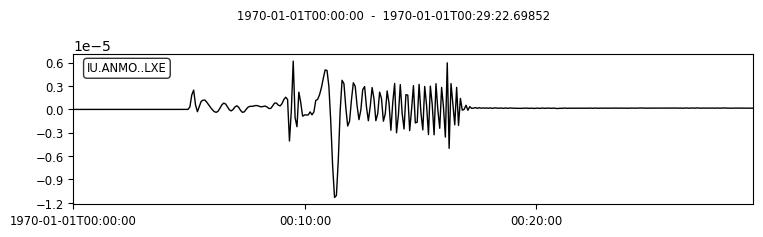

In [10]:
#plot 'observed' data
st_obs = obspy.read('../data/lab_03/moment_tensor_inversion/Observed*')
fig = st_obs.plot()

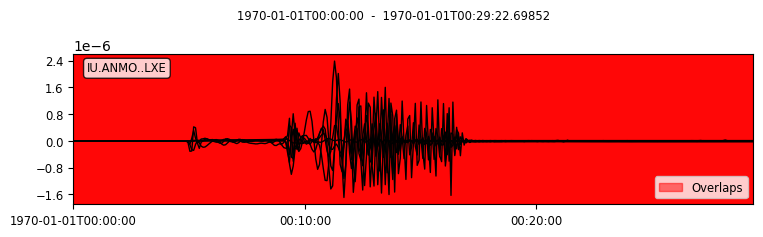

In [11]:
#plot Green's functions
st_syn = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*')
fig = st_syn.plot()

#Note, the plot turns red. Obspy is angry with you because you gave it multiple seismograms with the 
#same channel and station code. This is fine though, since there should be 6 Green's functions for ANMO!

Our problem is essentially to find some linear combination of the six Green's functions plotted above, that will reproduce the 'observed' data. Below, I provide functions to create both the $\mathbf{G}$ matrix (make_G), and the data vector $\mathbf{d}$ (make_d_vec).

In [12]:
def make_G():

    #read Green's functions
    G_m_rr = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*m_rr*.SAC')[0] #read m_rr Green's function
    G_m_tt = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*m_tt*.SAC')[0] #read m_tt Green's function
    G_m_pp = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*m_pp*.SAC')[0] #read m_pp Green's function
    G_m_rt = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*m_rt*.SAC')[0] #read m_rt Green's function
    G_m_rp = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*m_rp*.SAC')[0] #read m_rp Green's function
    G_m_tp = obspy.read('../data/lab_03/moment_tensor_inversion/Greens*m_tp*.SAC')[0] #read m_tp Green's function
    
    #turn the Green's functions into a numpy array
    G = np.array((G_m_rr.data,G_m_tt.data,G_m_pp.data,G_m_rt.data,G_m_rp.data,G_m_tp.data))
    G = G.T #transpose row and column vectors- the line above sets the Green's functions as rows
    
    return G

In [13]:
def make_d_vec():
    
    tr = obspy.read('../data/lab_03/moment_tensor_inversion/Observed*.SAC')[0]
    data_vec = tr.data
            
    return data_vec

###  <font color='red'>Question 7 </font>
Use the functions make_G and make_d_vec to build the $\mathbf{G}$ and $\mathbf{d}$. Then, use numpy.linalg.solve to solve the system of equations. What is the best fitting moment tensor?

Hint: Remember, numpy.linalg.solve returns a list, the first of which is the best fitting model. In this case, it should be a list of the 6 model parameters, which correspond to the values of [$M_{RR}, M_{\theta\theta}, M_{\phi\phi}, M_{R\theta}, M_{R\phi}, M_{\theta\phi}$]

In [14]:
#Answer Question 7 here.


###  <font color='red'>Question 8 </font>
To generate the synthetic Green's functions, each force couple used a scalar moment of $1x10^{14}$ Nm. This means that in order to find the values of each moment tensor component in the units of Nm, each component of your best fitting solution should be scaled by $1x10^{14}$. Knowing this, what is the scalar moment $M_0$ of the source, in Nm?

Hint, you can find the scalar moment using 
$M_0 = \frac{1}{\sqrt{2}}(\sum_{ij}M_{ij}^2)^{1/2}$

In [15]:
#Answer Q8 here


###  <font color='red'>Question 9 </font>
We can plot a 'beachball' diagram of the moment tensor using Obspy's imaging.beachball function. This function takes a list of the six independent moment tensor components (the same way we have been ordering things, [$M_{RR}, M_{\theta\theta}, M_{\phi\phi}, M_{R\theta}, M_{R\phi}, M_{\theta\phi}$]). Plot your best fitting moment tensor. What type of source is it? What tectonic stress regime would you expect to see this source?

Hint: An example of how to plot a moment tensor is given below. Also, the units are unimportant when plotting. It does not need to be in Nm.

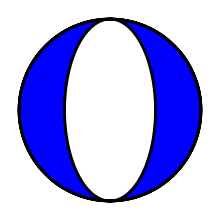

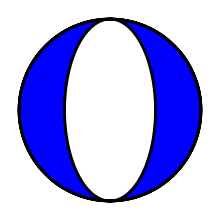

In [16]:
from obspy.imaging.beachball import beachball
mt = [-1,0,1,0,0,0]
beachball(mt)

In [17]:
#Answer Q9 here.
